In [1]:
import csv, os
import numpy as np
from IPython.core.display import HTML, clear_output

In [2]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [3]:
with open('./topics_index.tsv', 'r', encoding="utf8") as f:
    res = csv.DictReader(f, delimiter='\t')
    ret = list(res)
    
# data = [c for u in ret for c in list(u['op'])]
unique = list(set([u['op'] for u in ret]))
data = list('\n'.join(unique))

In [4]:
# data I/O
# data = open('input.txt', 'r').read() # should be simple plain text file

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print( 'data has %d characters, %d unique.' % (data_size, vocab_size) )
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 207388 characters, 97 unique.


In [125]:
sample_count = 100

# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
seq_length = len(unique) // 1000 # number of steps to unroll the RNN for
learning_rate = 2e-2

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

n, p = 0, 0
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad

In [109]:
seq_length

19

In [126]:
# LOAD BUTTON
with np.load('./params.npz') as f:
    # print( list(f) )
    global Wxh, Whh, Why, bh, by
    Wxh = f['Wxh']; Whh = f['Whh']; Why = f['Why']; bh = f['bh']; by = f['by']

In [220]:
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, char_to_ix['\n'], sample_count)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    
    clear_output(wait=True)
    print( '----\n%s\n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print( 'iter %d, loss: %f' % (n, smooth_loss) ) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

----
ariokiosan
Ruckomayucat
Laseroapar446
AxBins
nia41000
tiedoBadio
Paakyja
fascandeo
Annvor561
termake
----
iter 15000, loss: 54.462465


KeyboardInterrupt: 

In [384]:
seed = np.random.randn(hidden_size, 1) # np.random.uniform(size=(hidden_size,1))
# hprev # np.zeros((hidden_size,1))

print(''.join(ix_to_char[ix] for ix in sample(seed,char_to_ix['\n'],200)))
# seed.T

Shioteru
SloznCron
sireyure96

gneettarttutst
Rebapuner
qayltarast
Liakkiretu
Craz ZonVec
Iperfist
tilacheasmu
8877
areksinNeEbter
Criactem
Fripestrattockod
9weydort
jogink
EnZe75
Sharidrfarger
Draybe


In [285]:
# SAVE BUTTON
with open('./params.npz', 'wb') as f:
    np.savez(f, Wxh=Wxh, Whh=Whh, Why=Why, bh=bh, by=by)

## TensorFlow version

In [3]:
import tensorflow as tf
tf.enable_eager_execution()

In [4]:
''.join(data[:250])

'tathagata71\nTogie\nergzay\nDur Faer\nghostmech553\nGIGALON\niondot\nxlapin\nhrw8133\n\ncoffeybeans\nParatus\nLizardcreatures\nAlienScientist\nPedoKiller\nzolar89\nFranchestcreator\nGandZombie\nasonne1\nCheezburgur\nfuego10000\nLiamWA\njoshfish22\ncreeper11825\nflibberjab\nK'

In [6]:
# https://www.tensorflow.org/tutorials/sequences/text_generation
    
# data = [c for u in ret for c in list(u['op'])]
vocab = sorted(set(data))
    
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text = data
text_as_int = np.array([char2idx[c] for c in text])

In [7]:
text_as_int.shape

(207388,)

In [9]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

t
a
t
h
a


In [10]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

'tathagata71\nTogie\nergzay\nDur Faer\nghostmech553\nGIGALON\niondot\nxlapin\nhrw8133\n\ncoffeybeans\nParatus\nLiz'
'ardcreatures\nAlienScientist\nPedoKiller\nzolar89\nFranchestcreator\nGandZombie\nasonne1\nCheezburgur\nfuego1'
'0000\nLiamWA\njoshfish22\ncreeper11825\nflibberjab\nKingSender\nKalem14\nAwbee\nMaxx1224\nSuperg17\nHigueraa\nDo'
'gger\nFurryDaddyDave\nStrife47\nwizaerd\nblackicmenace\nBlitz08\nKilljoy08\nlilartistgrrl\nbobobo55585\nKateno'
'hate\nlemter\nrampho\n5superguy5\nRandomyeto\nBlueberry51\nRay67\ncarbon493\nRDrakewind\nwaymack91xj\nYanustek\n'


In [12]:
# https://github.com/crazydonkey200/tensorflow-char-rnn/blob/master/train.py
# params = {'batch_size': 20, 'num_unrollings': 10, 'hidden_size': 256,
          # 'max_grad_norm': 5., 'embedding_size': 0, 'num_layers': 2,
          # 'learning_rate': .002, 'dropout': 0., 'input_dropout': 0.}

# Batch size 
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences, 
# so it doesn't attempt to shuffle the entire sequence in memory. Instead, 
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

In [13]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
# The embedding dimension 
embedding_dim = 256
# Number of RNN units
rnn_units = 1024

if tf.test.is_gpu_available():
  rnn = tf.keras.layers.CuDNNGRU
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    rnn(rnn_units,
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [14]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)

In [15]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 97) # (batch_size, sequence_length, vocab_size)


In [47]:
np.random.multinomial(5, example_batch_predictions[0])

TypeError: object of type 'EagerTensor' has no len()

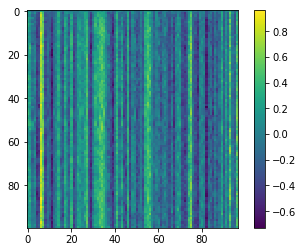

In [37]:
from matplotlib import pyplot as plt
plt.imshow(np.array(example_batch_predictions[0]), interpolation='nearest')
plt.colorbar()
plt.show()

In [24]:
# https://github.com/tensorflow/tensorflow/issues/24949
sampled_indices = np.random.multinomial(1, np.array(example_batch_predictions[0]))#, num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

ValueError: object too deep for desired array

In [17]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 97)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       11.056052


In [ ]:
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [34]:
EPOCHS=3
history = model.fit(dataset.repeat(), epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch)#, callbacks=[checkpoint_callback])

Epoch 1/3
32/32 [==============================] - 165s 5s/step - loss: 4.1693
Epoch 2/3
32/32 [==============================] - 158s 5s/step - loss: 3.6661
Epoch 3/3
32/32 [==============================] - 173s 5s/step - loss: 3.7656


In [39]:
generate_text(model, start_string=u" \n")

ValueError: Tensor's shape (64, 2, 1024) is not compatible with supplied shape [Dimension(1), Dimension(2), 1024]

In [35]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing) 
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

#### Test serialization roundtrip

In [6]:
# 20495, 22  # taxonomy shop
# 45652, 1   # short-lived evolution game reboot
# 300, 800   # autohotkey script to fix graphics?
# 34634, 7148 # linux joke

with open('./{}.tsv'.format(20495), 'r') as f:
    ret = list( csv.DictReader(f, delimiter='\t') )
    for i,u in enumerate(ret):
        print( i, u['user'], u['date'] )

FileNotFoundError: [Errno 2] No such file or directory: './20495.tsv'

In [20]:
dirs = [d for d in os.listdir('.') if any(c.isdigit() for c in d)]
tsvs = ['/'.join(['.',d,f]) for d in dirs for f in os.listdir(d)]

In [33]:
with open(path, 'r') as f:
    res = csv.DictReader(f, delimiter='\t')
    ret = list(res)
    
ret[0]

OrderedDict([('id', '2357223'),
             ('user', 'OsakaSun'),
             ('date', '06/23/2010 19:31:46'),
             ('content',
              '<div class="postbody" style="overflow-x:auto; width: 650px;">This is a guide on realism. Now, I know exactly what you’re thinking:<br/> <br/> <i>Why the hell did you make a guide on realism?! It’s a roleplaying section! Half the stuff here is sci-fi and fantasy and whatnot! Nothing is realistic!</i><br/> <br/> Yes. That’s all very true, but that isn’t the exact kind of realism I’m talking about. For those of you who do roleplays with aliens and robots and all that, you can just skip the section on characters if you want to be like that, but you all should read this anyways. I’m talking about the stuff that ticks me off like hell because people can’t seem to make their characters act realistic, or else can’t make their actions within the normal human limitations. That may seem a little harsh, but it’s so effin’ true that I’m wasting my 

In [26]:
csv.field_size_limit(1000000)
for path in tsvs:
    with open(path, 'r') as f:
        print( len(list( csv.DictReader(f, delimiter='\t') )))

461
655
587
423
353
331
318
323
542
348
444
519
492
345
387
430
680
310
378
320
672
300
325
379
685
292
623
433
374
559
611
360
291
476
351
297
541
308
602
614
528
296
689
638
648
350
298
474
362
325
421
402
673
435
401
683
317
301
735
344
491
338
537
636
420
469
382
406
294
609
604
352
521
423
727
403
379
330
678
359
466
515
548
479
684
397
612
340
293
694
315
351
626
439
430
291
353
512
304
328
382
452
410
514
529
488
348
679
325
679
642
341
438
431
465
303
361
629
571
595
651
401
670
286
420
426
457
328
619
601
457
330
681
427
383
289
579
467
659
314
353
426
347
343
668
452
289
707
472
446
481
292
337
449
621
292
726
659
393
555
360
410
423
372
398
493
561
331
346
561
423
397
313
605
558
406
333
307
605
658
584
288
307
325
306
308
328
577
357
660
458
556
603
708
728
310
330
380
534
364
338
614
515
680
326
484
699
510
697
514
644
358
695
375
462
347
305
327
713
486
318
548
577
480
474
669
380
676
420
466
346
408
648
659
715
294
702
446
423
672
677
443
319
15
543
712
618
449
582
388
5

64
185
96
273
90
99
114
101
103
62
81
273
133
64
179
106
239
113
274
226
176
209
211
244
104
68
190
136
200
151
253
112
148
102
92
150
93
70
74
94
61
127
85
95
116
201
69
126
131
145
135
167
247
208
71
275
180
222
246
195
106
66
67
262
162
115
109
75
227
88
95
90
70
68
67
66
62
69
111
190
98
103
71
160
94
267
84
266
79
91
61
80
79
97
197
73
124
135
142
73
62
88
115
145
72
86
81
66
104
195
211
72
283
67
267
176
106
86
208
73
62
171
154
172
100
85
181
68
241
63
261
68
72
182
177
91
133
139
150
105
103
167
175
64
237
121
76
76
134
68
220
266
68
187
68
85
220
204
137
98
183
61
107
112
65
62
139
91
65
71
118
94
225
245
174
99
71
164
98
97
82
93
205
257
82
82
281
70
69
73
155
156
81
65
263
85
167
72
89
103
131
89
272
70
100
133
93
178
75
88
111
87
65
65
66
135
218
63
90
275
153
64
182
220
81
108
164
271
147
69
134
111
81
155
66
157
164
222
75
153
71
87
80
126
137
75
276
61
82
269
115
103
244
106
92
278
115
48
78
151
80
62
63
109
53
66
68
79
65
113
148
86
164
106
240
85
123
249
106
196
71
67


47
6
22
3
4
23
4
40
9
25
3
19
17
23
18
34
4
5
4
1
5
30
21
6
3
12
4
46
23
6
2
8
20
30
8
59
6
14
3
4
3
3
26
42
35
10
4
32
41
13
10
33
26
44
45
9
11
15
20
34
16
8
3
1
21
17
6
3
1
3
18
4
14
4
12
3
10
1
16
7
10
33
1
30
4
12
2
8
2
10
50
6
1
4
6
38
9
10
21
27
34
1
33
7
5
19
19
20
1
48
7
4
2
13
26
2
6
4
45
32
46
17
1
3
19
9
4
44
2
1
45
32
6
14
1
9
23
13
50
38
8
2
19
60
25
36
15
3
20
23
27
10
11
12
53
10
5
25
7
17
7
13
3
4
52
7
8
8
35
5
7
7
51
21
12
31
13
30
6
24
38
42
37
49
13
5
25
7
27
4
45
21
6
45
21
1
29
5
1
30
2
6
32
6
44
8
9
58
1
6
23
5
11
18
9
7
21
3
12
6
36
30
35
20
20
3
2
30
7
4
9
15
39
57
3
5
13
46
4
22
14
16
11
9
26
55
20
24
10
16
2
21
4
33
8
36
5
3
4
3
15
10
16
16
5
2
35
18
3
6
11
36
6
14
28
21
32
41
10
18
19
15
40
52
46
37
31
14
2
11
3
22
29
6
7
14
3
7
1
13
7
9
6
13
10
9
17
5
3
2
5
17
8
10
11
23
13
11
17
8
6
7
27
14
5
57
12
52
19
16
20
9
5
19
36
5
16
55
2
25
30
19
1
2
8
10
7
13
18
21
12
1
29
30
9
4
6
49
29
5
19
6
38
12
1
30
5
39
26
44
6
1
16
3
7
4
1
9
11
45
13
35
40
19
1
3
3
1
17
3

8
33
2
32
58
11
1
25
36
58
45
10
8
18
24
8
23
19
25
3
9
8
2
37
13
34
3
10
8
1
10
7
5
5
1
14
48
8
5
10
2
3
3
4
17
11
13
7
14
53
3
2
3
10
20
8
16
37
27
15
38
20
13
3
18
21
13
54
15
32
14
24
37
8
4
2
6
7
10
58
6
33
3
6
1
12
20
50
59
13
6
30
9
31
34
23
26
8
9
20
14
13
8
2
13
46
6
9
41
12
5
40
5
6
28
32
5
5
2
2
19
27
8
36
3
16
3
6
2
18
15
17
5
8
3
1
5
14
11
4
1
3
1
47
2
12
3
50
11
3
2
8
12
6
4
3
46
11
17
28
5
38
8
12
23
17
37
17
8
6
47
14
2
26
3
21
49
8
19
46
3
31
12
4
39
24
42
16
25
11
20
5
33
13
2
49
11
3
23
30
8
6
5
14
5
26
12
1
56
9
2
29
16
4
5
10
1
6
15
2
3
52
23
13
11
4
16
16
55
3
8
17
21
8
7
8
49
4
17
58
18
13
5
6
3
5
15
5
2
22
30
43
3
22
22
12
11
5
10
52
2
1
1
17
5
28
29
6
41
15
7
6
21
25
17
4
3
9
12
15
9
2
7
51
4
30
16
49
6
22
5
18
16
55
29
5
9
42
15
2
31
25
22
2
13
36
26
6
51
27
12
22
12
6
31
4
6
10
11
18
40
21
22
4
28
14
24
2
13
4
41
33
1
30
12
34
56
1
11
29
11
48
3
33
20
3
5
9
10
11
1
11
28
8
14
1
19
4
6
4
8
33
7
7
24
12
11
3
3
11
16
23
14
24
3
3
9
17
16
8
59
3
5
10
4
17
11
7
34

3
45
13
10
5
19
22
13
20
22
22
4
6
45
7
9
34
29
5
8
8
22
14
4
6
3
10
13
26
5
23
25
25
1
1
25
5
2
14
6
16
3
12
1
25
9
42
36
49
23
23
19
4
17
13
46
22
4
44
41
3
34
14
4
12
10
13
11
17
12
15
33
9
34
17
5
12
15
12
2
9
2
2
5
4
5
42
34
6
7
7
21
3
13
40
41
2
3
47
15
36
35
37
50
3
55
9
14
59
4
6
2
31
4
24
21
9
20
45
12
19
26
10
12
2
6
11
14
48
15
6
18
38
6
4
9
6
4
3
15
4
33
19
6
18
34
19
6
2
6
2
27
37
12
14
2
16
14
3
7
5
3
7
29
52
6
26
0
13
2
23
13
15
17
3
6
4
1
3
10
20
1
19
2
49
2
24
8
4
21
6
5
6
9
5
2
2
4
15
3
2
1
9
10
33
31
42
5
6
40
2
25
21
6
15
38
3
15
20
9
17
49
8
29
1
1
3
20
11
40
18
58
22
4
28
9
3
19
10
39
3
50
5
9
1
11
7
6
16
3
7
18
51
37
24
8
6
8
3
5
15
8
17
2
7
2
31
22
3
23
23
4
23
11
23
28
43
14
2
27
2
7
13
3
23
27
42
19
15
14
16
1
12
22
7
9
11
18
10
32
4
17
43
13
8
12
12
37
3
24
56
1
41
26
24
39
11
13
1
29
23
35
5
46
24
16
6
6
12
15
1
3
8
2
15
4
15
57
2
9
14
14
24
3
4
12
57
4
17
9
7
21
33
6
11
5
16
19
7
42
9
7
6
2
17
11
14
3
5
15
46
4
22
56
14
8
4
4
17
28
17
38
7
2
40
29
47
23
17


In [ ]:
# strip markup
#print( '\n'.join([(el.text or '') + ' ' + (el.tail or '')
#                  for el in etree.fromstring(ret[800]['content']).iter('*')]) )

# TODO: trim tabs but not spaces.
HTML(ret[0]['content'])

#### Repair utilities

In [ ]:
import os
for root,dirs,files in os.walk('.'):
    for file in files:
        if file.endswith(".tsv"):
            with open('./{}'.format(file), 'r') as f:
                ret = list( csv.DictReader(f, delimiter='\t') )
                try:
                    for line in ret:
                        if 'textarea' in line['content']:
                            print(file, 'codeblock')
                            break
                except:
                    print(file, 'trouble')